Dataset Shape: (385, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Station Name              385 non-null    object
 1   Street Address            385 non-null    object
 2   City                      385 non-null    object
 3   Access Days Time          385 non-null    object
 4   EV Level1 EVSE Num        385 non-null    object
 5   EV Level2 EVSE Num        385 non-null    object
 6   EV DC Fast Count          385 non-null    object
 7   EV Other Info             385 non-null    object
 8   New Georeferenced Column  385 non-null    object
dtypes: object(9)
memory usage: 27.2+ KB

Cleaned Dataset Shape: (385, 11)


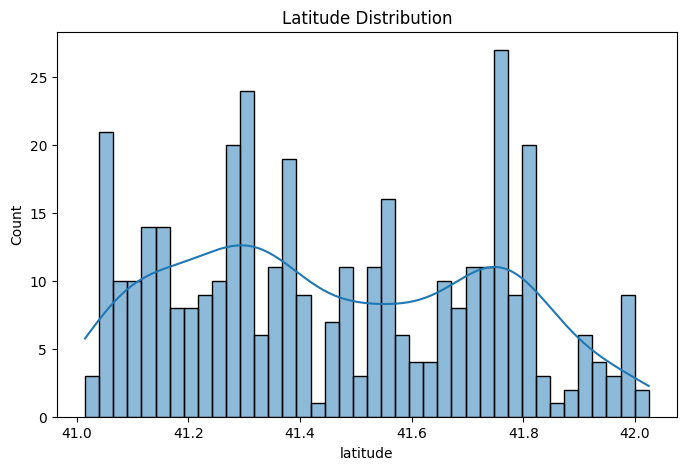

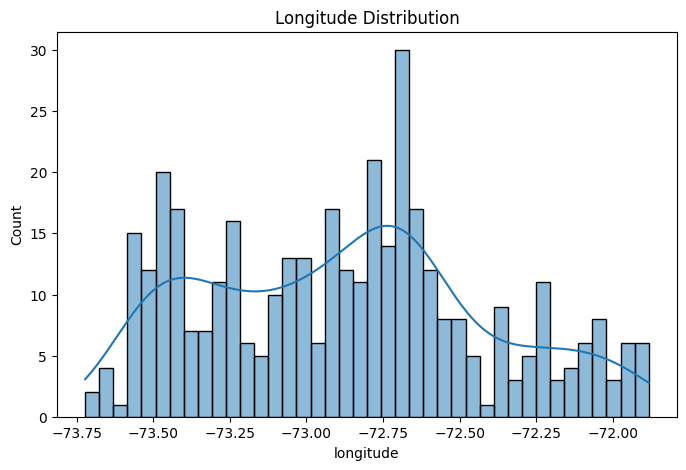


K-Means Clustering completed with 30 clusters.
cluster_id
2     34
18    34
25    27
12    24
9     22
Name: count, dtype: int64


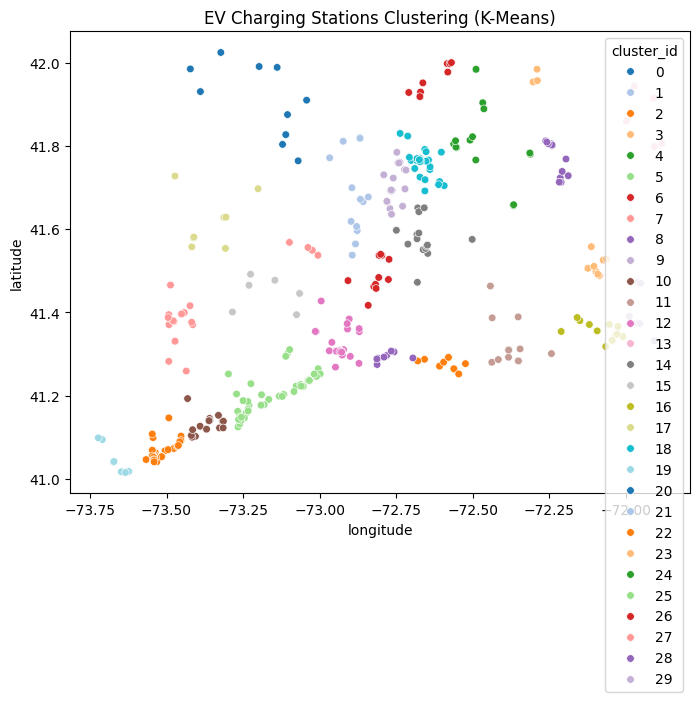

✅ Interactive Map Saved: EV_Charging_Stations_Map.html
✅ Data with clusters saved to CSV file.

Summary of Analysis:
→ Total Charging Stations Analyzed: 385
→ Clusters Formed: 30
→ Interactive map and processed data exported successfully.


In [2]:
# 🧠PROJECT - Electric Vehicle Charging Stations 2024
# Author: Shubhrat Chaursiya
# Dataset: https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-charging-stations-2024
# ----------------------------------------------------------------------------------------------
# Objective:
# Analyze EV charging station data, clean and cluster it geographically, and visualize the results
# using K-Means clustering and interactive maps.
# ----------------------------------------------------------------------------------------------

# ---------------- 1. Import Libraries ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import folium
from folium.plugins import MarkerCluster
import re # Import the regular expression module

# ---------------- 2. Load Dataset ----------------
file_path = "/content/EV_Charging_Stations_with_Clusters.csv"  # Update if different
df = pd.read_csv(file_path)
df.head()

# ---------------- 3. Basic Information ----------------
print("Dataset Shape:", df.shape)
df.info()
df.describe()

# ---------------- 4. Data Cleaning ----------------
# Rename columns for consistency
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Extract latitude and longitude from 'new_georeferenced_column'
def extract_lat_lon(point_str):
    if pd.isna(point_str):
        return None, None
    match = re.search(r'POINT \((-\d+\.?\d*) (\d+\.?\d*)\)', point_str)
    if match:
        return float(match.group(2)), float(match.group(1)) # Latitude comes before longitude
    return None, None

df['latitude'], df['longitude'] = zip(*df['new_georeferenced_column'].apply(extract_lat_lon))

# Drop duplicates and missing latitude/longitude
df = df.drop_duplicates()
df = df.dropna(subset=['latitude', 'longitude'])

# Keep only valid coordinates
df = df[(df['latitude'].between(-90, 90)) & (df['longitude'].between(-180, 180))]
print("\nCleaned Dataset Shape:", df.shape)

# ---------------- 5. Exploratory Data Analysis (EDA) ----------------
plt.figure(figsize=(8, 5))
sns.histplot(df['latitude'], bins=40, kde=True)
plt.title("Latitude Distribution")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['longitude'], bins=40, kde=True)
plt.title("Longitude Distribution")
plt.show()

if 'power_kw' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df['power_kw'], bins=30, kde=True)
    plt.title("Power Output Distribution (kW)")
    plt.show()

# ---------------- 6. K-Means Clustering ----------------
coords = df[['latitude', 'longitude']].values
n_clusters = 30

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df['cluster_id'] = kmeans.fit_predict(coords)

print("\nK-Means Clustering completed with", n_clusters, "clusters.")
print(df['cluster_id'].value_counts().head())

# ---------------- 7. Visualize Cluster Distribution ----------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster_id', data=df, palette='tab20', s=30)
plt.title("EV Charging Stations Clustering (K-Means)")
plt.show()

# ---------------- 8. Build Nearest Station Finder ----------------
tree = KDTree(np.radians(coords))
def find_nearest_station(lat, lon, k=1):
    """Find the nearest charging station(s) to a given coordinate."""
    dist, idx = tree.query(np.radians([[lat, lon]]), k=k)
    return df.iloc[idx[0]]

# Example usage (commented):
# print(find_nearest_station(28.6139, 77.2090, k=3))  # New Delhi example

# ---------------- 9. Interactive Map ----------------
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster_id']}"
    ).add_to(marker_cluster)

# Add cluster centers
for i, (lat, lon) in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        [lat, lon],
        icon=folium.Icon(color='red', icon='bolt', prefix='fa'),
        popup=f"Cluster Center {i}"
    ).add_to(m)

m.save("EV_Charging_Stations_Map.html")
print("✅ Interactive Map Saved: EV_Charging_Stations_Map.html")

# ---------------- 10. Save Results ----------------
df.to_csv("EV_Charging_Stations_with_Clusters.csv", index=False)
print("✅ Data with clusters saved to CSV file.")

# ---------------- 11. Summary ----------------
print("\nSummary of Analysis:")
print(f"→ Total Charging Stations Analyzed: {len(df)}")
print(f"→ Clusters Formed: {n_clusters}")
print("→ Interactive map and processed data exported successfully.")